Globally averaged temperature:

$$
\frac{dT}{dt} = R_i(T) -  R_0(T, C)
$$


$$
R_i(T) = \frac{Q_0}{c} (1 - p \alpha_\text{land} - p \alpha_\text{oc}(T)) 
$$

$$
R_o(T) = \frac{1}{c} (\kappa (T - T_\kappa) - a \ln (\frac{C}{C_0}) )
$$


Accumulated anthropogenic carbon, $S_a$
$$
\frac{d S_a}{dt} = C_a
$$

Atmospheric carbon concentration:

$$
\frac{dC}{dt} = v + C_a - W_a A_v C g^{vege}(T) + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))
$$

Temperature anomaly:
$$
\tilde{T} = T - T_{preindustrial}
$$



$$
\begin{align}
\delta \phi(\tilde{T}, C, S_a) =& \max_{C_a} \eta \log C_a  \\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d\tilde{T}} \left( R_i(T) - R_0(T, C) \right)\\
& + \frac{d\phi(\tilde{T}, C, S_a)}{d C} \left( v + C_a - W_a A_v C g^{vege}(T) + \frac{c_0}{\tau_c} \kappa_P (1 - f(T)) + \frac{c_0}{\tau_c} \kappa_B(S_a) (1 - f(T)) - \frac{\lambda}{\tau_c} C(1 - f(T))\right)\\
& + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} C_a \\
& + \frac{(\eta - 1)}{\delta} (\gamma_1 + \gamma_2 \tilde{T}) (R_i(T) - R_0(T, C))
\end{align}
$$

$$
C_a^{*} = - \frac{ \eta}{\frac{d \phi (\tilde{T}, C, S_a)}{d C} + \frac{d \phi (\tilde{T}, C, S_a)}{d S_a} }
$$

In [1]:
import sys
sys.path.append("../src/")
import numpy as np
import pandas as pd
import pickle
from scipy.integrate import solve_ivp
from scipy.fft import fft, fftfreq
from matplotlib import pyplot as plt
from matplotlib import rcParams
from matplotlib.colors import SymLogNorm
import matplotlib.mlab
import scipy.io as sio
import pandas as pd
import scipy.optimize as optim
from scipy.optimize import curve_fit
from scipy import interpolate
from scipy import fft, arange, signal
from scipy.interpolate import RegularGridInterpolator
import SolveLinSys
from supportfunctions import finiteDiff
rcParams["figure.figsize"] = (8,5)
rcParams["savefig.bbox"] = 'tight'
                                                                                
def PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, 
              ε = 1, tol = -10):                                              
                                                                                 

    A = A.reshape(-1,1,order = 'F')                                         
    B = np.hstack([B1.reshape(-1,1,order = 'F'),B2.reshape(-1,1,order = 'F'),B3.reshape(-1,1,order='F')])
    C = np.hstack([C1.reshape(-1,1,order = 'F'),C2.reshape(-1,1,order = 'F'),C3.reshape(-1,1,order='F')])
    D = D.reshape(-1,1,order = 'F')                                         
    v0 = v0.reshape(-1,1,order = 'F')                                       
    out = SolveLinSys.solveFT(stateSpace, A, B, C, D, v0, ε, tol)           

    return out                                                            

In [2]:
# Pre-industrial: 282.87K

sa = 1
Ts = 282.9
Cs = 275.5

Q0 = 342.5
p = 0.3
# outgoing radiation linearized
kappa = 1.74
Tkappa = 154
## CO2 radiative forcing
# Greenhouse effect parameter
B = 5.35

alphaland = 0.28
bP = 0.05
bB = 0.08
cod = 3.035
cearth = 10. # 35 #0.107
tauc = 20.

cearth = 35.
tauc   = 6603.

coc0 =350
## Ocean albedo parameters
Talphaocean_low = 219
Talphaocean_high = 299
alphaocean_max = 0.84
alphaocean_min = 0.255

Cbio_low = 50
Cbio_high = 700

T0 = 298
C0 = 280

## CO2 uptake by vegetation
wa = 0.015
vegcover = 0.4

Thigh = 315
Tlow = 282
Topt1 = 295
Topt2 = 310
acc = 5

## Volcanism
Volcan = 0.028


def alphaocean(T):
    """T, matrix, (nT, nC, nF)"""
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = alphaocean_max
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = alphaocean_min

    return temp
    
#Fraction of ocean covered by ice
def fracseaice(T):
    
    temp = np.zeros(T.shape)
    temp[ T< Talphaocean_low ] = 1
    temp[ (T>= Talphaocean_low)&(T< Talphaocean_high)] = 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T[(T>= Talphaocean_low)&(T< Talphaocean_high)] - Talphaocean_low)
    temp[T>= Talphaocean_high] = 0

    return temp
    


def biopump(F):
    """F, accumulated anthrpogenic emission"""
    temp = np.zeros(F.shape)
    
    temp[F < Cbio_low] = 1
    temp[(F >= Cbio_low)&(F < Cbio_high)] = 1 - 1/(Cbio_high - Cbio_low) * (F[(F >= Cbio_low)&(F < Cbio_high)] - Cbio_low)
    temp[F >= Cbio_high] = 0
    return temp


def veggrowth(T):
    
    temp = np.zeros(T.shape)
    
    temp[T < Tlow] = 0
    temp[(T >= Tlow)&(T < Topt1)] = acc / (Topt1 - Tlow) * (T[(T >= Tlow)&(T < Topt1)] - Tlow)
    temp[(T >= Topt1)&(T < Topt2)] = acc
    temp[(T >= Topt2)&(T < Thigh)] = acc / (Topt2 - Thigh) * (T[(T >= Topt2)&(T < Thigh)] - Thigh)
    temp[T > Thigh] = 0
    
    return temp


#Incoming radiation modified by albedo
def Ri(T):
    return 1/cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(T)))

# Outgoing radiation modified by greenhouse effect
def Ro(T, C):
    return 1/cearth * (kappa * (T - Tkappa) -  B * np.log(C / C0))

#Solubility of atmospheric carbon into the oceans
# carbon pumps
def kappaP(T):
    return np.exp(-bP * (T - T0))

def oceanatmphysflux(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def oceanbioflux(T, F, sa):
    
    if sa == 1:
        
        return 1/tauc * (coc0 * (np.exp(bB * biopump(F) * (T - T0))))
    
    elif sa == 0:
        
        return 1/tauc * (coc0 * (np.exp(bB * (T - T0))))
    
    else:
        return ValueError("Wrong input value: 0 or 1.")

def oceanatmcorrflux(C):
    return 1 / tauc * (- cod * C)

In [3]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta   = 0.01
eta     = 0.032

# State variable
# Temperature anomaly, in celsius
T_min  = 0. 
T_max  = 20. # 
hT     = 0.1
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, in gigaton
C_min  = 250
C_max  = 500
hC     = 10
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon, in gigaton
F_min = 280. # 10. avaoid 
F_max = 2500. # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 50.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(201, 26, 46)

In [4]:
To = 282.87 # Mean with no anthropogenic carbon emissions, in Fᵒ

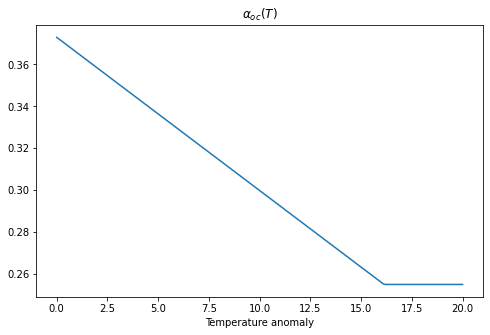

(0.255, 0.372950625)

In [5]:
α_ocean = alphaocean(T_grid + To)
plt.plot(T_grid, α_ocean)
plt.xlabel("Temperature anomaly")
plt.title("$α_{oc}(T)$")
plt.show()
α_ocean.min(), α_ocean.max()

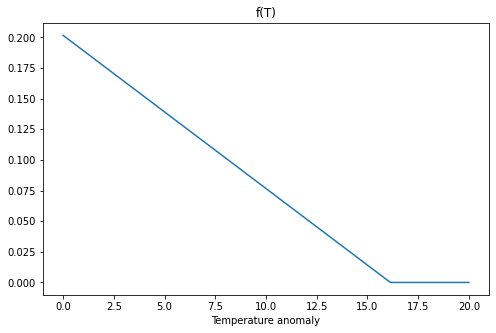

(0.0, 0.20162499999999994)

In [6]:
frac_sea_ice = fracseaice(T_grid + To)
plt.plot(T_grid, frac_sea_ice)
plt.xlabel("Temperature anomaly")
plt.title("f(T)")
plt.show()
frac_sea_ice.min(), frac_sea_ice.max()

In [7]:
frac_sea_ice.mean()

0.08140298507462679

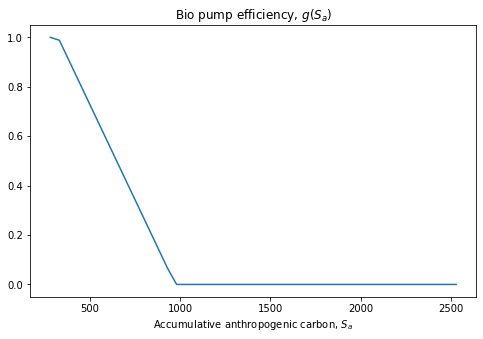

In [8]:
Fo = 272.3 # pre-industrial cumulated emission
bio_pump_efficiency = biopump(F_grid - Fo)
plt.plot(F_grid, bio_pump_efficiency)
plt.xlabel("Accumulative anthropogenic carbon, $S_a$")
plt.title("Bio pump efficiency, $g(S_a)$")
plt.show()

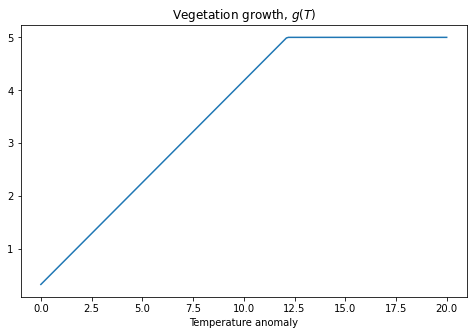

(0.33461538461538637, 5.0)

In [9]:
vege_growth = veggrowth(To + T_grid)


plt.plot(T_grid, vege_growth)
plt.xlabel("Temperature anomaly")
plt.title("Vegetation growth, $g(T)$")
plt.show()

vege_growth.min(), vege_growth.max()

In [10]:
vege_growth.mean()

3.5806352851128977

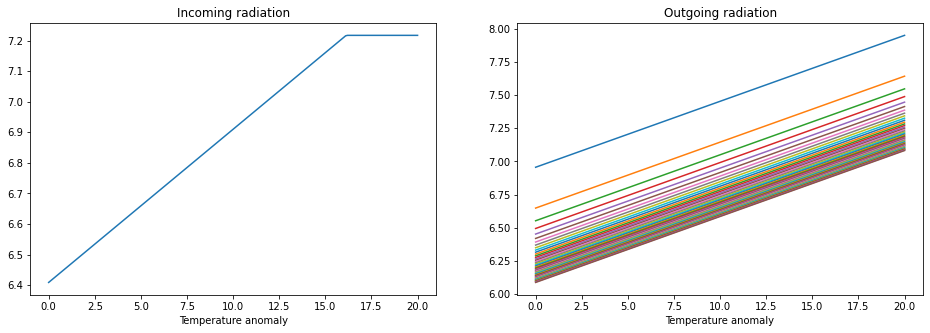

In [11]:
plt.subplots(1,2, figsize=(16, 5))
plt.subplot(121)

plt.title("Incoming radiation")
ri = Ri(To + T_grid)
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :] - Fo)
plt.plot(T_grid, ri)
plt.xlabel("Temperature anomaly")

plt.subplot(122)
plt.title("Outgoing radiation")
plt.plot(T_grid, ro)
plt.xlabel("Temperature anomaly")
plt.show()

Text(0.5, 0, 'Temperature anomaly')

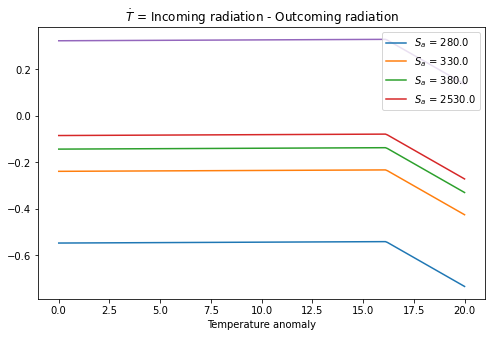

In [12]:
plt.title("$\\dot{T}$ = Incoming radiation - Outcoming radiation")
ri = Ri(To + T_mat[:, 0, :])
ro = Ro(To + T_mat[:, 0, :], F_mat[:,0, :] - Fo)
plt.plot(T_grid, (ri - ro)[:, [0, 1,2,3, -1]])
plt.legend(["$S_a$ = {}".format(F) for F in F_grid[[0, 1, 2,-1]]])
plt.xlabel("Temperature anomaly")

In [13]:
T_grid[5], F_grid[17], C_grid[1]

(0.5, 1130.0, 260)

In [14]:
(ri - ro)[6, 17], 10 * 1.86/1000

(0.17366649657357502, 0.018600000000000002)

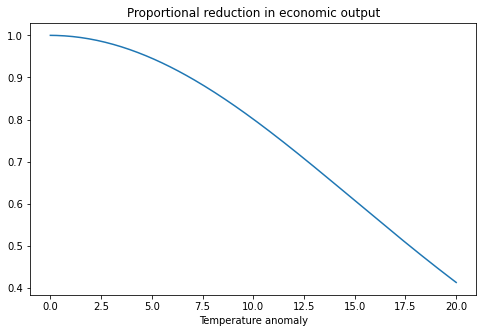

In [15]:
dG  = gamma_1 + gamma_2 * T_grid
G = gamma_1 * T_grid + gamma_2 / 2 * T_grid**2
plt.plot(T_grid, np.exp( -G) )
plt.xlabel("Temperature anomaly")
plt.title("Proportional reduction in economic output")
plt.show()

In [16]:
# Economic paramaters
gamma_1 = 1.7675 / 10000.
gamma_2 = 2 * 0.0022
delta   = 0.01
eta     = 0.032

# State variable
# Temperature anomaly, in celsius
T_min  = 1e-8 
T_max  = 10. # 
hT     = 0.2
T_grid = np.arange(T_min, T_max + hT, hT)

# atmospheric carbon concentration, in ppm
C_min  = 200
C_max  = 400.
hC     = 4.
C_grid = np.arange(C_min, C_max + hC, hC)

# F, Sa in the notes, accumulative anthropogenic carbon, in gigaton, since 1800
F_min = 1e-8 # 10. avoid 
F_max = 2000. # 2500 x2.13 gm # # on hold -> 4000 / 2.13 ppm
hF = 40.
F_grid = np.arange(F_min, F_max + hF, hF)

# meshgrid
(T_mat, C_mat, F_mat) = np.meshgrid(T_grid, C_grid, F_grid, indexing="ij")
stateSpace = np.hstack([
    T_mat.reshape(-1, 1, order="F"),
    C_mat.reshape(-1, 1, order="F"),
    F_mat.reshape(-1, 1, order="F")
])

T_mat.shape

(51, 51, 51)

In [17]:
cearth = 35.
tauc   = 6603.

# v0 = pickle.load(open("data_35.0_6603", "rb"))["v0"]
v0 =  - eta * T_mat - eta * F_mat
# v0 =  delta * eta * np.log(delta /4 * (9000/2.13 - F_mat)) + (eta - 1) * gamma_2 * T_mat / cearth * (B * np.log(C_mat/ C0) + kappa * (T_mat + To - Tkappa))

dG  = gamma_1 + gamma_2 * T_mat
epsilon  = 0.1
count    = 0
error    = 1.
tol      = 1e-8
max_iter = 5000
fraction = 0.1


while error > tol and count < max_iter:
    
    dvdT  = finiteDiff(v0, 0, 1, hT)
    dvdTT = finiteDiff(v0, 0, 2, hT)
    dvdC  = finiteDiff(v0, 1, 1, hC)
#     dvdC[dvdC >= - 1e-16] = - 1e-16
    dvdCC = finiteDiff(v0, 1, 2, hC)
    dvdF  = finiteDiff(v0, 2, 1, hF)
    dvdFF = finiteDiff(v0, 2, 2, hF)
        

    Ca = - eta * delta / (dvdC + dvdF)

    Ca[Ca <= 1e-32] = 1e-32
    
    if count >=1:
        Ca = Ca * fraction + Ca_star * (1 - fraction)
    
#     Ca = np.ones(T_mat.shape)
    A  = - delta * np.ones(T_mat.shape)
    B1 = Ri(T_mat + To) - Ro(T_mat + To, C_mat)
    B2 = Volcan
    B2 += Ca * sa
    B2 -= wa * C_mat * vegcover * veggrowth(T_mat +To)
    B2 += oceanatmphysflux(T_mat + To)  * (1 - fracseaice(T_mat + To))
    B2 += oceanbioflux(T_mat + To, F_mat, sa) * (1 - fracseaice(T_mat + To))
    B2 += oceanatmcorrflux(C_mat) * (1 - fracseaice(T_mat + To))
    B3 = Ca
    C1 = 0.0 * np.ones(T_mat.shape)
    C2 = 0.0 * np.ones(T_mat.shape)
    C3 = np.zeros(T_mat.shape)
    D  = eta * delta * np.log(Ca) + (eta - 1) * dG * B1

    out = PDESolver(stateSpace, A, B1, B2, B3, C1, C2, C3, D, v0, epsilon)
    v = out[2].reshape(v0.shape, order="F")

    rhs_error = A * v0 + B1 * dvdT + B2 * dvdC + B3 * dvdF + C1 * dvdTT + C2 * dvdCC + C3 * dvdFF + D
    rhs_error = np.max(abs(rhs_error))
    lhs_error = np.max(abs((v - v0)/epsilon))

    error = lhs_error
    v0 = v
    Ca_star = Ca
    count += 1

    print("Iteration: %s;\t False Transient Error: %s;\t PDE Error: %s\t" % (count, lhs_error, rhs_error))

print("Total iteration: %s;\t LHS Error: %s;\t RHS Error %s\t" % (count, lhs_error, rhs_error))

Iteration: 1;	 False Transient Error: 0.644178376023774;	 PDE Error: 0.6447965742974096	
Iteration: 2;	 False Transient Error: 0.6435606644261327;	 PDE Error: 0.6441783857158223	
Iteration: 3;	 False Transient Error: 0.6429434298813419;	 PDE Error: 0.6435606741640476	
Iteration: 4;	 False Transient Error: 0.6423266724328869;	 PDE Error: 0.6429434396883265	
Iteration: 5;	 False Transient Error: 0.6417103921123868;	 PDE Error: 0.6423266823240054	
Iteration: 6;	 False Transient Error: 0.6410945889437158;	 PDE Error: 0.6417104020973525	
Iteration: 7;	 False Transient Error: 0.6404792629427902;	 PDE Error: 0.6410945990274681	
Iteration: 8;	 False Transient Error: 0.6398644141207654;	 PDE Error: 0.6404792731274256	
Iteration: 9;	 False Transient Error: 0.6392500424831127;	 PDE Error: 0.6398644244052291	
Iteration: 10;	 False Transient Error: 0.6386361480316793;	 PDE Error: 0.6392500528648488	
Iteration: 11;	 False Transient Error: 0.6380227307647601;	 PDE Error: 0.6386361585067097	
Iteration

Iteration: 92;	 False Transient Error: 0.5899179134275556;	 PDE Error: 0.590492812277533	
Iteration: 93;	 False Transient Error: 0.5893434987446966;	 PDE Error: 0.5899179245773474	
Iteration: 94;	 False Transient Error: 0.5887695569819584;	 PDE Error: 0.5893435098887413	
Iteration: 95;	 False Transient Error: 0.5881960880463311;	 PDE Error: 0.588769568120017	
Iteration: 96;	 False Transient Error: 0.5876230918445202;	 PDE Error: 0.5881960991785663	
Iteration: 97;	 False Transient Error: 0.5870505682818106;	 PDE Error: 0.587623102970872	
Iteration: 98;	 False Transient Error: 0.5864785172632736;	 PDE Error: 0.5870505794024788	
Iteration: 99;	 False Transient Error: 0.5859069386924176;	 PDE Error: 0.5864785283780255	
Iteration: 100;	 False Transient Error: 0.5853358324716851;	 PDE Error: 0.5859069498012461	
Iteration: 101;	 False Transient Error: 0.5847651985036606;	 PDE Error: 0.5853358435748988	
Iteration: 102;	 False Transient Error: 0.5841950366887261;	 PDE Error: 0.5847652096009046	

Iteration: 183;	 False Transient Error: 0.5395691624266874;	 PDE Error: 0.5401014990047835	
Iteration: 184;	 False Transient Error: 0.5390372976161473;	 PDE Error: 0.5395691730549923	
Iteration: 185;	 False Transient Error: 0.5385058937718412;	 PDE Error: 0.5390373082387891	
Iteration: 186;	 False Transient Error: 0.5379749507261522;	 PDE Error: 0.5385059043889759	
Iteration: 187;	 False Transient Error: 0.5374444683101842;	 PDE Error: 0.5379749613376504	
Iteration: 188;	 False Transient Error: 0.5369144463548992;	 PDE Error: 0.5374444789161849	
Iteration: 189;	 False Transient Error: 0.536384884690051;	 PDE Error: 0.5369144569552388	
Iteration: 190;	 False Transient Error: 0.5358557831449673;	 PDE Error: 0.5363848952847575	
Iteration: 191;	 False Transient Error: 0.5353271415477678;	 PDE Error: 0.5358557937339308	
Iteration: 192;	 False Transient Error: 0.5347989597265723;	 PDE Error: 0.5353271521312577	
Iteration: 193;	 False Transient Error: 0.5342712375085057;	 PDE Error: 0.5347989

Iteration: 273;	 False Transient Error: 0.4935260306142908;	 PDE Error: 0.49401761339956257	
Iteration: 274;	 False Transient Error: 0.493034901424636;	 PDE Error: 0.49352604074364076	
Iteration: 275;	 False Transient Error: 0.49254421547288985;	 PDE Error: 0.49303491154851303	
Iteration: 276;	 False Transient Error: 0.4920539725355866;	 PDE Error: 0.4925442255912396	
Iteration: 277;	 False Transient Error: 0.4915641723884079;	 PDE Error: 0.4920539826483509	
Iteration: 278;	 False Transient Error: 0.4910748148073907;	 PDE Error: 0.49156418249586015	
Iteration: 279;	 False Transient Error: 0.4905858995672929;	 PDE Error: 0.49107482490930454	
Iteration: 280;	 False Transient Error: 0.4900974264425173;	 PDE Error: 0.49058590966368126	
Iteration: 281;	 False Transient Error: 0.4896093952071112;	 PDE Error: 0.49009743653345794	
Iteration: 282;	 False Transient Error: 0.4891218056349089;	 PDE Error: 0.4896094052926745	
Iteration: 283;	 False Transient Error: 0.48863465749839463;	 PDE Error: 

Iteration: 362;	 False Transient Error: 0.4515247211276119;	 PDE Error: 0.45197776126803635	
Iteration: 363;	 False Transient Error: 0.4510721124983519;	 PDE Error: 0.45152473077082916	
Iteration: 364;	 False Transient Error: 0.4506199254717558;	 PDE Error: 0.4510721221361385	
Iteration: 365;	 False Transient Error: 0.45016815978740965;	 PDE Error: 0.4506199351040119	
Iteration: 366;	 False Transient Error: 0.4497168151844022;	 PDE Error: 0.4501681694141217	
Iteration: 367;	 False Transient Error: 0.44926589140217743;	 PDE Error: 0.44971682480582453	
Iteration: 368;	 False Transient Error: 0.4488153881793977;	 PDE Error: 0.44926590101819897	
Iteration: 369;	 False Transient Error: 0.4483653052545833;	 PDE Error: 0.4488153977899777	
Iteration: 370;	 False Transient Error: 0.4479156423654729;	 PDE Error: 0.44836531485960135	
Iteration: 371;	 False Transient Error: 0.4474663992503025;	 PDE Error: 0.447915651965156	
Iteration: 372;	 False Transient Error: 0.44701757564624245;	 PDE Error: 0

Iteration: 452;	 False Transient Error: 0.4125860638514922;	 PDE Error: 0.41298202688603897	
Iteration: 453;	 False Transient Error: 0.41217659597535317;	 PDE Error: 0.4125719551105067	
Iteration: 454;	 False Transient Error: 0.4117676386595548;	 PDE Error: 0.4121623735596501	
Iteration: 455;	 False Transient Error: 0.4113591598780175;	 PDE Error: 0.4117532997572806	
Iteration: 456;	 False Transient Error: 0.410951166456357;	 PDE Error: 0.41134476257989183	
Iteration: 457;	 False Transient Error: 0.4105437172261617;	 PDE Error: 0.4109367120021094	
Iteration: 458;	 False Transient Error: 0.4101367434234504;	 PDE Error: 0.4105291474255949	
Iteration: 459;	 False Transient Error: 0.409730244494213;	 PDE Error: 0.410122096945446	
Iteration: 460;	 False Transient Error: 0.4093242619892834;	 PDE Error: 0.40971556731026604	
Iteration: 461;	 False Transient Error: 0.4089187834269836;	 PDE Error: 0.40930983041935987	
Iteration: 462;	 False Transient Error: 0.40851377695787505;	 PDE Error: 0.408

Iteration: 542;	 False Transient Error: 0.37736717252116136;	 PDE Error: 0.37774285128597723	
Iteration: 543;	 False Transient Error: 0.376991818661665;	 PDE Error: 0.377367159637851	
Iteration: 544;	 False Transient Error: 0.37661680244440277;	 PDE Error: 0.3769918057950348	
Iteration: 545;	 False Transient Error: 0.37624212370573673;	 PDE Error: 0.3766167895943896	
Iteration: 546;	 False Transient Error: 0.3758677822816736;	 PDE Error: 0.3762421108723749	
Iteration: 547;	 False Transient Error: 0.37549377800793593;	 PDE Error: 0.3758677694650676	
Iteration: 548;	 False Transient Error: 0.3751201107196067;	 PDE Error: 0.37549376520797395	
Iteration: 549;	 False Transient Error: 0.3747467802516269;	 PDE Error: 0.37512009793635737	
Iteration: 550;	 False Transient Error: 0.3743737864380847;	 PDE Error: 0.37474676748491814	
Iteration: 551;	 False Transient Error: 0.37400112911313954;	 PDE Error: 0.3743737736880295	
Iteration: 552;	 False Transient Error: 0.37362880811024013;	 PDE Error: 

Iteration: 632;	 False Transient Error: 0.3449173653089588;	 PDE Error: 0.34526334171035855	
Iteration: 633;	 False Transient Error: 0.3445716990749048;	 PDE Error: 0.3449173538600525	
Iteration: 634;	 False Transient Error: 0.3442263542782342;	 PDE Error: 0.34457168764127316	
Iteration: 635;	 False Transient Error: 0.34388133072432936;	 PDE Error: 0.3442263428596776	
Iteration: 636;	 False Transient Error: 0.3435366282180041;	 PDE Error: 0.3438813193207254	
Iteration: 637;	 False Transient Error: 0.343192246564783;	 PDE Error: 0.34353661682976977	
Iteration: 638;	 False Transient Error: 0.34284818556884034;	 PDE Error: 0.3431922351915031	
Iteration: 639;	 False Transient Error: 0.34250444503477695;	 PDE Error: 0.34284817421071523	
Iteration: 640;	 False Transient Error: 0.3421610247666962;	 PDE Error: 0.34250443369175815	
Iteration: 641;	 False Transient Error: 0.34181792456848825;	 PDE Error: 0.3421610134387682	
Iteration: 642;	 False Transient Error: 0.3414751442436881;	 PDE Error: 

Iteration: 722;	 False Transient Error: 0.3150712888709606;	 PDE Error: 0.31538912553193127	
Iteration: 723;	 False Transient Error: 0.31475374529577493;	 PDE Error: 0.31507127872412094	
Iteration: 724;	 False Transient Error: 0.3144365047546671;	 PDE Error: 0.31475373516278793	
Iteration: 725;	 False Transient Error: 0.314119567034723;	 PDE Error: 0.3144364946353439	
Iteration: 726;	 False Transient Error: 0.3138029319230995;	 PDE Error: 0.31411955692911664	
Iteration: 727;	 False Transient Error: 0.31348659920698907;	 PDE Error: 0.3138029218312947	
Iteration: 728;	 False Transient Error: 0.3131705686732644;	 PDE Error: 0.31348658912893074	
Iteration: 729;	 False Transient Error: 0.31285484010862064;	 PDE Error: 0.3131705586088615	
Iteration: 730;	 False Transient Error: 0.3125394132996462;	 PDE Error: 0.3128548300578873	
Iteration: 731;	 False Transient Error: 0.3122242880330006;	 PDE Error: 0.3125394032626664	
Iteration: 732;	 False Transient Error: 0.3119094640948461;	 PDE Error: 0

Iteration: 812;	 False Transient Error: 0.2876807288047445;	 PDE Error: 0.2879721391545204	
Iteration: 813;	 False Transient Error: 0.28738959317085033;	 PDE Error: 0.28768071983961346	
Iteration: 814;	 False Transient Error: 0.2870987410102188;	 PDE Error: 0.2873895842183231	
Iteration: 815;	 False Transient Error: 0.28680817210176457;	 PDE Error: 0.2870987320700422	
Iteration: 816;	 False Transient Error: 0.28651788622525487;	 PDE Error: 0.2868081631741871	
Iteration: 817;	 False Transient Error: 0.286227883159782;	 PDE Error: 0.2865178773100737	
Iteration: 818;	 False Transient Error: 0.2859381626847224;	 PDE Error: 0.2862278742571022	
Iteration: 819;	 False Transient Error: 0.2856487245792749;	 PDE Error: 0.28593815379445325	
Iteration: 820;	 False Transient Error: 0.2853595686227095;	 PDE Error: 0.2856487157014465	
Iteration: 821;	 False Transient Error: 0.2850706945940473;	 PDE Error: 0.28535955975725175	
Iteration: 822;	 False Transient Error: 0.2847821022725938;	 PDE Error: 0.2

Iteration: 902;	 False Transient Error: 0.2625878505297763;	 PDE Error: 0.26285461548312816	
Iteration: 903;	 False Transient Error: 0.2623213414519654;	 PDE Error: 0.26258784263711077	
Iteration: 904;	 False Transient Error: 0.26205509593275167;	 PDE Error: 0.2623213335706127	
Iteration: 905;	 False Transient Error: 0.26178911375133396;	 PDE Error: 0.26205508806274586	
Iteration: 906;	 False Transient Error: 0.2615233946868756;	 PDE Error: 0.2617891058926899	
Iteration: 907;	 False Transient Error: 0.2612579385186109;	 PDE Error: 0.26152338683955284	
Iteration: 908;	 False Transient Error: 0.26099274502570324;	 PDE Error: 0.2612579306825579	
Iteration: 909;	 False Transient Error: 0.26072781398749356;	 PDE Error: 0.26099273720092797	
Iteration: 910;	 False Transient Error: 0.2604631451831807;	 PDE Error: 0.2607278061739779	
Iteration: 911;	 False Transient Error: 0.26019873839228325;	 PDE Error: 0.2604631373809552	
Iteration: 912;	 False Transient Error: 0.25993459339385794;	 PDE Erro

Iteration: 992;	 False Transient Error: 0.23963174667624543;	 PDE Error: 0.2398756519290693	
Iteration: 993;	 False Transient Error: 0.2393880785871616;	 PDE Error: 0.2396317397566883	
Iteration: 994;	 False Transient Error: 0.23914465437609778;	 PDE Error: 0.23938807167795995	
Iteration: 995;	 False Transient Error: 0.2389014738269779;	 PDE Error: 0.23914464747703185	
Iteration: 996;	 False Transient Error: 0.23865853672440096;	 PDE Error: 0.23890146693826672	
Iteration: 997;	 False Transient Error: 0.23841584285300144;	 PDE Error: 0.23865852984603117	
Iteration: 998;	 False Transient Error: 0.23817339199709409;	 PDE Error: 0.23841583598479146	
Iteration: 999;	 False Transient Error: 0.23793118394138446;	 PDE Error: 0.23817338513911507	
Iteration: 1000;	 False Transient Error: 0.2376892184706847;	 PDE Error: 0.23793117709364217	
Iteration: 1001;	 False Transient Error: 0.23744749536959375;	 PDE Error: 0.23768921163306697	
Iteration: 1002;	 False Transient Error: 0.2372060144231014;	 P

Iteration: 1080;	 False Transient Error: 0.21909905453828316;	 PDE Error: 0.2193222966299617	
Iteration: 1081;	 False Transient Error: 0.21887603183831317;	 PDE Error: 0.21909904848262562	
Iteration: 1082;	 False Transient Error: 0.2186532343879577;	 PDE Error: 0.21887602579206006	
Iteration: 1083;	 False Transient Error: 0.218430661980058;	 PDE Error: 0.21865322835104753	
Iteration: 1084;	 False Transient Error: 0.21820831440741983;	 PDE Error: 0.2184306559524223	
Iteration: 1085;	 False Transient Error: 0.21798619146345288;	 PDE Error: 0.21820830838918714	
Iteration: 1086;	 False Transient Error: 0.21776429294117605;	 PDE Error: 0.21798618545444337	
Iteration: 1087;	 False Transient Error: 0.21754261863375035;	 PDE Error: 0.21776428694138297	
Iteration: 1088;	 False Transient Error: 0.21732116833497628;	 PDE Error: 0.217542612643358	
Iteration: 1089;	 False Transient Error: 0.21709994183801484;	 PDE Error: 0.2173211623537522	
Iteration: 1090;	 False Transient Error: 0.216878938936879

Iteration: 1168;	 False Transient Error: 0.2003128534575893;	 PDE Error: 0.20051703663095752	
Iteration: 1169;	 False Transient Error: 0.2001088726780509;	 PDE Error: 0.20031284818679274	
Iteration: 1170;	 False Transient Error: 0.1999050993751439;	 PDE Error: 0.2001088674157573	
Iteration: 1171;	 False Transient Error: 0.19970153335229668;	 PDE Error: 0.19990509412129293	
Iteration: 1172;	 False Transient Error: 0.19949817441350604;	 PDE Error: 0.1997015281070034	
Iteration: 1173;	 False Transient Error: 0.1992950223623069;	 PDE Error: 0.1994981691765829	
Iteration: 1174;	 False Transient Error: 0.19909207700294473;	 PDE Error: 0.19929501713391065	
Iteration: 1175;	 False Transient Error: 0.19888933813927423;	 PDE Error: 0.1990920717829088	
Iteration: 1176;	 False Transient Error: 0.1986868055757185;	 PDE Error: 0.19888933292772173	
Iteration: 1177;	 False Transient Error: 0.19848447911659406;	 PDE Error: 0.19868680037257272	
Iteration: 1178;	 False Transient Error: 0.1982823585663240

Iteration: 1256;	 False Transient Error: 0.1831355196917528;	 PDE Error: 0.1833221661674106	
Iteration: 1257;	 False Transient Error: 0.1829490595377692;	 PDE Error: 0.18313551513333182	
Iteration: 1258;	 False Transient Error: 0.18276279008698992;	 PDE Error: 0.18294905498708403	
Iteration: 1259;	 False Transient Error: 0.18257671115485152;	 PDE Error: 0.1827627855439986	
Iteration: 1260;	 False Transient Error: 0.1823908225568971;	 PDE Error: 0.18257670661950304	
Iteration: 1261;	 False Transient Error: 0.1822051241088829;	 PDE Error: 0.18239081802925486	
Iteration: 1262;	 False Transient Error: 0.1820196156268139;	 PDE Error: 0.1822051195889393	
Iteration: 1263;	 False Transient Error: 0.18183429692644637;	 PDE Error: 0.18201961111446338	
Iteration: 1264;	 False Transient Error: 0.18164916782428264;	 PDE Error: 0.18183429242186652	
Iteration: 1265;	 False Transient Error: 0.1814642281363632;	 PDE Error: 0.18164916332726488	
Iteration: 1266;	 False Transient Error: 0.1812794776791904

Iteration: 1344;	 False Transient Error: 0.16743711259259442;	 PDE Error: 0.16760765321606758	
Iteration: 1345;	 False Transient Error: 0.1672667432204733;	 PDE Error: 0.16743710867998	
Iteration: 1346;	 False Transient Error: 0.16709654884696334;	 PDE Error: 0.16726673931482233	
Iteration: 1347;	 False Transient Error: 0.16692652929982899;	 PDE Error: 0.1670965449482846	
Iteration: 1348;	 False Transient Error: 0.16675668440694125;	 PDE Error: 0.16692652540812977	
Iteration: 1349;	 False Transient Error: 0.16658701399652642;	 PDE Error: 0.166756680522249	
Iteration: 1350;	 False Transient Error: 0.16641751789645554;	 PDE Error: 0.166587010118676	
Iteration: 1351;	 False Transient Error: 0.1662481959353812;	 PDE Error: 0.1664175140256283	
Iteration: 1352;	 False Transient Error: 0.16607904794167183;	 PDE Error: 0.166248192071439	
Iteration: 1353;	 False Transient Error: 0.16591007374369582;	 PDE Error: 0.166079044084524	
Iteration: 1354;	 False Transient Error: 0.16574127317049658;	 PD

Iteration: 1432;	 False Transient Error: 0.1531858113088269;	 PDE Error: 0.15333926553826416	
Iteration: 1433;	 False Transient Error: 0.1530325139646571;	 PDE Error: 0.15318581627098324	
Iteration: 1434;	 False Transient Error: 0.15287936839690985;	 PDE Error: 0.15303251892458275	
Iteration: 1435;	 False Transient Error: 0.1527263744613272;	 PDE Error: 0.15287937335463214	
Iteration: 1436;	 False Transient Error: 0.15257353201375778;	 PDE Error: 0.15272637941683104	
Iteration: 1437;	 False Transient Error: 0.15242084091005026;	 PDE Error: 0.15257353696700152	
Iteration: 1438;	 False Transient Error: 0.15226830100644406;	 PDE Error: 0.1524208458611043	
Iteration: 1439;	 False Transient Error: 0.152115912159001;	 PDE Error: 0.15226830595521942	
Iteration: 1440;	 False Transient Error: 0.15196367422412038;	 PDE Error: 0.15211591710555772	
Iteration: 1441;	 False Transient Error: 0.1518115870583081;	 PDE Error: 0.15196367916846162	
Iteration: 1442;	 False Transient Error: 0.15165965051799

Iteration: 1520;	 False Transient Error: 0.14026110512240564;	 PDE Error: 0.140401729167485	
Iteration: 1521;	 False Transient Error: 0.1401206255397014;	 PDE Error: 0.14026110989234375	
Iteration: 1522;	 False Transient Error: 0.13998028551352348;	 PDE Error: 0.14012063030742125	
Iteration: 1523;	 False Transient Error: 0.13984008491062738;	 PDE Error: 0.13998029027916076	
Iteration: 1524;	 False Transient Error: 0.13970002359762645;	 PDE Error: 0.13984008967411365	
Iteration: 1525;	 False Transient Error: 0.1395601014412584;	 PDE Error: 0.13970002835895268	
Iteration: 1526;	 False Transient Error: 0.13942031830850965;	 PDE Error: 0.1395601062004716	
Iteration: 1527;	 False Transient Error: 0.13928067406631328;	 PDE Error: 0.1394203230655768	
Iteration: 1528;	 False Transient Error: 0.1391411685819932;	 PDE Error: 0.13928067882130044	
Iteration: 1529;	 False Transient Error: 0.13900180172262466;	 PDE Error: 0.13914117333478274	
Iteration: 1530;	 False Transient Error: 0.13886257335567

Iteration: 1607;	 False Transient Error: 0.1285475785309309;	 PDE Error: 0.12867653665017525	
Iteration: 1608;	 False Transient Error: 0.12841875350511955;	 PDE Error: 0.12854758311852754	
Iteration: 1609;	 False Transient Error: 0.12829005685940587;	 PDE Error: 0.12841875809062314	
Iteration: 1610;	 False Transient Error: 0.12816148847031528;	 PDE Error: 0.1282900614428677	
Iteration: 1611;	 False Transient Error: 0.12803304821460415;	 PDE Error: 0.12816149305177416	
Iteration: 1612;	 False Transient Error: 0.12790473596886898;	 PDE Error: 0.12803305279396401	
Iteration: 1613;	 False Transient Error: 0.1277765516099727;	 PDE Error: 0.12790474054617396	
Iteration: 1614;	 False Transient Error: 0.1276484950149026;	 PDE Error: 0.12777655618525185	
Iteration: 1615;	 False Transient Error: 0.12752056606075257;	 PDE Error: 0.12764849958814842	
Iteration: 1616;	 False Transient Error: 0.12739276462466975;	 PDE Error: 0.12752057063193095	
Iteration: 1617;	 False Transient Error: 0.12726509058

Iteration: 1695;	 False Transient Error: 0.11768911895739365;	 PDE Error: 0.11780722975942012	
Iteration: 1696;	 False Transient Error: 0.11757113060916424;	 PDE Error: 0.11768912336788627	
Iteration: 1697;	 False Transient Error: 0.11745326018806068;	 PDE Error: 0.11757113501767558	
Iteration: 1698;	 False Transient Error: 0.11733550757998756;	 PDE Error: 0.1174532645946001	
Iteration: 1699;	 False Transient Error: 0.1172178726709916;	 PDE Error: 0.11733551198457445	
Iteration: 1700;	 False Transient Error: 0.11710035534722607;	 PDE Error: 0.11721787707362095	
Iteration: 1701;	 False Transient Error: 0.11698295549480875;	 PDE Error: 0.11710035974785978	
Iteration: 1702;	 False Transient Error: 0.11686567300015938;	 PDE Error: 0.11698295989351841	
Iteration: 1703;	 False Transient Error: 0.11674850774976875;	 PDE Error: 0.1168656773969263	
Iteration: 1704;	 False Transient Error: 0.11663145963000332;	 PDE Error: 0.11674851214450863	
Iteration: 1705;	 False Transient Error: 0.1165145285

Iteration: 1783;	 False Transient Error: 0.10774528755241874;	 PDE Error: 0.10785343652131851	
Iteration: 1784;	 False Transient Error: 0.10763725120467527;	 PDE Error: 0.1077452917927398	
Iteration: 1785;	 False Transient Error: 0.10752932313049968;	 PDE Error: 0.10763725544311119	
Iteration: 1786;	 False Transient Error: 0.10742150322448296;	 PDE Error: 0.10752932736701082	
Iteration: 1787;	 False Transient Error: 0.10731379138144703;	 PDE Error: 0.10742150745912028	
Iteration: 1788;	 False Transient Error: 0.10720618749633815;	 PDE Error: 0.10731379561421299	
Iteration: 1789;	 False Transient Error: 0.10709869146396045;	 PDE Error: 0.10720619172715501	
Iteration: 1790;	 False Transient Error: 0.10699130317954442;	 PDE Error: 0.10709869569291593	
Iteration: 1791;	 False Transient Error: 0.10688402253807183;	 PDE Error: 0.10699130740655201	
Iteration: 1792;	 False Transient Error: 0.10677684943493304;	 PDE Error: 0.1068840267632259	
Iteration: 1793;	 False Transient Error: 0.106669783

Iteration: 1870;	 False Transient Error: 0.09874022358740575;	 PDE Error: 0.09883932779333068	
Iteration: 1871;	 False Transient Error: 0.09864122301996403;	 PDE Error: 0.09874022766563156	
Iteration: 1872;	 False Transient Error: 0.09854232191354839;	 PDE Error: 0.0986412270963384	
Iteration: 1873;	 False Transient Error: 0.09844352017092106;	 PDE Error: 0.09854232598809459	
Iteration: 1874;	 False Transient Error: 0.09834481769486203;	 PDE Error: 0.0984435242436282	
Iteration: 1875;	 False Transient Error: 0.09824621438831116;	 PDE Error: 0.09834482176576204	
Iteration: 1876;	 False Transient Error: 0.09814771015424384;	 PDE Error: 0.09824621845740343	
Iteration: 1877;	 False Transient Error: 0.09804930489583086;	 PDE Error: 0.09814771422155025	
Iteration: 1878;	 False Transient Error: 0.09795099851620748;	 PDE Error: 0.09804930896128557	
Iteration: 1879;	 False Transient Error: 0.09785279091850896;	 PDE Error: 0.09795100257978295	
Iteration: 1880;	 False Transient Error: 0.097754682

Iteration: 1958;	 False Transient Error: 0.09043054823855812;	 PDE Error: 0.0905380927426392	
Iteration: 1959;	 False Transient Error: 0.09034118987928608;	 PDE Error: 0.09044865610455638	
Iteration: 1960;	 False Transient Error: 0.09025192103807811;	 PDE Error: 0.09035930906282107	
Iteration: 1961;	 False Transient Error: 0.09016274162338078;	 PDE Error: 0.09027005152577311	
Iteration: 1962;	 False Transient Error: 0.09007365154376501;	 PDE Error: 0.09018088340184685	
Iteration: 1963;	 False Transient Error: 0.08998465070790829;	 PDE Error: 0.09009180459956934	
Iteration: 1964;	 False Transient Error: 0.08989573902461245;	 PDE Error: 0.09000281502755778	
Iteration: 1965;	 False Transient Error: 0.08980691640267935;	 PDE Error: 0.08991391459452643	
Iteration: 1966;	 False Transient Error: 0.0897181827510174;	 PDE Error: 0.08982510320927983	
Iteration: 1967;	 False Transient Error: 0.08962953797862383;	 PDE Error: 0.0897363807807131	
Iteration: 1968;	 False Transient Error: 0.0895409819

Iteration: 2046;	 False Transient Error: 0.08290388224438061;	 PDE Error: 0.08300381846855501	
Iteration: 2047;	 False Transient Error: 0.08282212304875358;	 PDE Error: 0.08292198818299099	
Iteration: 2048;	 False Transient Error: 0.082740445692977;	 PDE Error: 0.08284023981197586	
Iteration: 2049;	 False Transient Error: 0.08265885009331342;	 PDE Error: 0.08275857327182658	
Iteration: 2050;	 False Transient Error: 0.08257733616645169;	 PDE Error: 0.08267698847894098	
Iteration: 2051;	 False Transient Error: 0.08249590382895633;	 PDE Error: 0.08259548534980571	
Iteration: 2052;	 False Transient Error: 0.08241455299740963;	 PDE Error: 0.08251406380099043	
Iteration: 2053;	 False Transient Error: 0.08233328358873138;	 PDE Error: 0.08243272374914705	
Iteration: 2054;	 False Transient Error: 0.08225209551966373;	 PDE Error: 0.08235146511101596	
Iteration: 2055;	 False Transient Error: 0.08217098870728634;	 PDE Error: 0.08227028780341927	
Iteration: 2056;	 False Transient Error: 0.082089963

Iteration: 2133;	 False Transient Error: 0.07609121131108232;	 PDE Error: 0.07618234137464934	
Iteration: 2134;	 False Transient Error: 0.0760163277419057;	 PDE Error: 0.07610733338413712	
Iteration: 2135;	 False Transient Error: 0.07594151909868785;	 PDE Error: 0.07603240033540629	
Iteration: 2136;	 False Transient Error: 0.07586678530524082;	 PDE Error: 0.07595754215181191	
Iteration: 2137;	 False Transient Error: 0.07579212628544774;	 PDE Error: 0.0758827587567831	
Iteration: 2138;	 False Transient Error: 0.0757175419632361;	 PDE Error: 0.07580805007382957	
Iteration: 2139;	 False Transient Error: 0.07564303226264002;	 PDE Error: 0.07573341602653358	
Iteration: 2140;	 False Transient Error: 0.07556859710780017;	 PDE Error: 0.07565885653855693	
Iteration: 2141;	 False Transient Error: 0.07549423642283948;	 PDE Error: 0.07558437153363619	
Iteration: 2142;	 False Transient Error: 0.07541995013204073;	 PDE Error: 0.07550996093558447	
Iteration: 2143;	 False Transient Error: 0.0753457381

Iteration: 2221;	 False Transient Error: 0.06978060781523077;	 PDE Error: 0.0698641775670532	
Iteration: 2222;	 False Transient Error: 0.06971208407764884;	 PDE Error: 0.06979554438419472	
Iteration: 2223;	 False Transient Error: 0.06964362889443798;	 PDE Error: 0.06972697977532372	
Iteration: 2224;	 False Transient Error: 0.06957524219636468;	 PDE Error: 0.06965848367065253	
Iteration: 2225;	 False Transient Error: 0.06950692391429314;	 PDE Error: 0.06959005600046211	
Iteration: 2226;	 False Transient Error: 0.06943867397913195;	 PDE Error: 0.06952169669510394	
Iteration: 2227;	 False Transient Error: 0.06937049232185188;	 PDE Error: 0.06945340568500057	
Iteration: 2228;	 False Transient Error: 0.06930237887355695;	 PDE Error: 0.06938518290064166	
Iteration: 2229;	 False Transient Error: 0.06923433356533337;	 PDE Error: 0.0693170282725881	
Iteration: 2230;	 False Transient Error: 0.0691663563284628;	 PDE Error: 0.06924894173147036	
Iteration: 2231;	 False Transient Error: 0.0690984470

Iteration: 2308;	 False Transient Error: 0.06406832631811632;	 PDE Error: 0.06414238099524308	
Iteration: 2309;	 False Transient Error: 0.06400551539076815;	 PDE Error: 0.06407945987697357	
Iteration: 2310;	 False Transient Error: 0.06394276725963266;	 PDE Error: 0.064016601512778	
Iteration: 2311;	 False Transient Error: 0.06388008186161365;	 PDE Error: 0.06395380583859615	
Iteration: 2312;	 False Transient Error: 0.06381745913357939;	 PDE Error: 0.06389107279043031	
Iteration: 2313;	 False Transient Error: 0.0637548990124337;	 PDE Error: 0.06382840230434321	
Iteration: 2314;	 False Transient Error: 0.06369240143524912;	 PDE Error: 0.06376579431645925	
Iteration: 2315;	 False Transient Error: 0.06362996633913376;	 PDE Error: 0.06370324876296346	
Iteration: 2316;	 False Transient Error: 0.06356759366119569;	 PDE Error: 0.06364076558010226	
Iteration: 2317;	 False Transient Error: 0.06350528333870287;	 PDE Error: 0.06357834470418348	
Iteration: 2318;	 False Transient Error: 0.0634430353

Iteration: 2394;	 False Transient Error: 0.05889024782251617;	 PDE Error: 0.058956505694512246	
Iteration: 2395;	 False Transient Error: 0.058832642289292636;	 PDE Error: 0.05889881922392797	
Iteration: 2396;	 False Transient Error: 0.05877509434285777;	 PDE Error: 0.05884119040491762	
Iteration: 2397;	 False Transient Error: 0.058717603925515505;	 PDE Error: 0.05878361917955163	
Iteration: 2398;	 False Transient Error: 0.058660170979845105;	 PDE Error: 0.0587261054899563	
Iteration: 2399;	 False Transient Error: 0.05860279544838143;	 PDE Error: 0.05866864927831734	
Iteration: 2400;	 False Transient Error: 0.05854547727369486;	 PDE Error: 0.05861125048687831	
Iteration: 2401;	 False Transient Error: 0.05848821639854229;	 PDE Error: 0.058553909057941105	
Iteration: 2402;	 False Transient Error: 0.05843101276561846;	 PDE Error: 0.05849662493386555	
Iteration: 2403;	 False Transient Error: 0.05837386631773356;	 PDE Error: 0.05843939805706913	
Iteration: 2404;	 False Transient Error: 0.058

Iteration: 2480;	 False Transient Error: 0.05414088663840744;	 PDE Error: 0.05420037726455813	
Iteration: 2481;	 False Transient Error: 0.05408802922191924;	 PDE Error: 0.054147442837137016	
Iteration: 2482;	 False Transient Error: 0.05403522465591948;	 PDE Error: 0.054094561281578	
Iteration: 2483;	 False Transient Error: 0.053982472887739164;	 PDE Error: 0.05404173254457356	
Iteration: 2484;	 False Transient Error: 0.05392977386490472;	 PDE Error: 0.053988956572864705	
Iteration: 2485;	 False Transient Error: 0.05387712753480933;	 PDE Error: 0.05393623331324065	
Iteration: 2486;	 False Transient Error: 0.05382453384503272;	 PDE Error: 0.05388356271253957	
Iteration: 2487;	 False Transient Error: 0.05377199274318123;	 PDE Error: 0.05383094471764649	
Iteration: 2488;	 False Transient Error: 0.05371950417691451;	 PDE Error: 0.053778379275495974	
Iteration: 2489;	 False Transient Error: 0.053667068093909975;	 PDE Error: 0.05372586633307136	
Iteration: 2490;	 False Transient Error: 0.0536

Iteration: 2566;	 False Transient Error: 0.04978304315991444;	 PDE Error: 0.04983590610173226	
Iteration: 2567;	 False Transient Error: 0.04973454386012932;	 PDE Error: 0.04978732849269135	
Iteration: 2568;	 False Transient Error: 0.049686093071956705;	 PDE Error: 0.04973879933402912	
Iteration: 2569;	 False Transient Error: 0.04963769074703528;	 PDE Error: 0.049690318576072263	
Iteration: 2570;	 False Transient Error: 0.049589336837092546;	 PDE Error: 0.049641886169181804	
Iteration: 2571;	 False Transient Error: 0.04954103129373166;	 PDE Error: 0.049593502063752376	
Iteration: 2572;	 False Transient Error: 0.04949277406874231;	 PDE Error: 0.04954516621021432	
Iteration: 2573;	 False Transient Error: 0.049444565113985206;	 PDE Error: 0.04949687855903053	
Iteration: 2574;	 False Transient Error: 0.04939640438123227;	 PDE Error: 0.04944863906069962	
Iteration: 2575;	 False Transient Error: 0.04934829182242417;	 PDE Error: 0.04940044766575217	
Iteration: 2576;	 False Transient Error: 0.0

Iteration: 2652;	 False Transient Error: 0.04578454960090461;	 PDE Error: 0.045830300624103704	
Iteration: 2653;	 False Transient Error: 0.04574004959228439;	 PDE Error: 0.04578571129005011	
Iteration: 2654;	 False Transient Error: 0.04569559407602064;	 PDE Error: 0.04574116623912803	
Iteration: 2655;	 False Transient Error: 0.04565118300679849;	 PDE Error: 0.04569666542383451	
Iteration: 2656;	 False Transient Error: 0.045606816339285317;	 PDE Error: 0.045652208796682546	
Iteration: 2657;	 False Transient Error: 0.04556249402818402;	 PDE Error: 0.04560779631019942	
Iteration: 2658;	 False Transient Error: 0.045518216028277436;	 PDE Error: 0.04556342791692678	
Iteration: 2659;	 False Transient Error: 0.0454739822942507;	 PDE Error: 0.04551910356941872	
Iteration: 2660;	 False Transient Error: 0.045429792780931066;	 PDE Error: 0.045474823220244764	
Iteration: 2661;	 False Transient Error: 0.045385647443110244;	 PDE Error: 0.045430586821985815	
Iteration: 2662;	 False Transient Error: 0.

Iteration: 2738;	 False Transient Error: 0.04211556643021197;	 PDE Error: 0.04215645451312069	
Iteration: 2739;	 False Transient Error: 0.042074728691945396;	 PDE Error: 0.04211557608095722	
Iteration: 2740;	 False Transient Error: 0.04203393159376567;	 PDE Error: 0.04207473833351968	
Iteration: 2741;	 False Transient Error: 0.04199317509081091;	 PDE Error: 0.0420339412259955	
Iteration: 2742;	 False Transient Error: 0.04195245913820145;	 PDE Error: 0.04199318471355596	
Iteration: 2743;	 False Transient Error: 0.04191178369113757;	 PDE Error: 0.041952468751353215	
Iteration: 2744;	 False Transient Error: 0.04187114870471298;	 PDE Error: 0.04191179329452482	
Iteration: 2745;	 False Transient Error: 0.04183055413402137;	 PDE Error: 0.04187115829818887	
Iteration: 2746;	 False Transient Error: 0.04178999993413868;	 PDE Error: 0.04183056371744462	
Iteration: 2747;	 False Transient Error: 0.041749486060176366;	 PDE Error: 0.041790009507372085	
Iteration: 2748;	 False Transient Error: 0.0417

Iteration: 2824;	 False Transient Error: 0.038747414941751046;	 PDE Error: 0.03878496948219138	
Iteration: 2825;	 False Transient Error: 0.038709905343270457;	 PDE Error: 0.03874742315006585	
Iteration: 2826;	 False Transient Error: 0.03867243240420759;	 PDE Error: 0.03870991352558671	
Iteration: 2827;	 False Transient Error: 0.038634996076112316;	 PDE Error: 0.03867244056031886	
Iteration: 2828;	 False Transient Error: 0.038597596310410154;	 PDE Error: 0.038635004205762984	
Iteration: 2829;	 False Transient Error: 0.03856023305845557;	 PDE Error: 0.03859760441335601	
Iteration: 2830;	 False Transient Error: 0.038522906271576396;	 PDE Error: 0.03856024113446963	
Iteration: 2831;	 False Transient Error: 0.03848561590098942;	 PDE Error: 0.03852291432041137	
Iteration: 2832;	 False Transient Error: 0.03844836189789369;	 PDE Error: 0.038485623922423176	
Iteration: 2833;	 False Transient Error: 0.03841114421339498;	 PDE Error: 0.03844836989168256	
Iteration: 2834;	 False Transient Error: 0.

Iteration: 2910;	 False Transient Error: 0.03565048035165663;	 PDE Error: 0.03568505846796215	
Iteration: 2911;	 False Transient Error: 0.03561593978484989;	 PDE Error: 0.03565048553498941	
Iteration: 2912;	 False Transient Error: 0.035581431489370985;	 PDE Error: 0.03561594492603534	
Iteration: 2913;	 False Transient Error: 0.035546955412435466;	 PDE Error: 0.035581436588339274	
Iteration: 2914;	 False Transient Error: 0.03551251150128998;	 PDE Error: 0.03554696046913434	
Iteration: 2915;	 False Transient Error: 0.035478099703127874;	 PDE Error: 0.03551251651565071	
Iteration: 2916;	 False Transient Error: 0.03544371996517359;	 PDE Error: 0.035478104675115585	
Iteration: 2917;	 False Transient Error: 0.03540937223466489;	 PDE Error: 0.03544372489475615	
Iteration: 2918;	 False Transient Error: 0.0353750564588351;	 PDE Error: 0.035409377121801866	
Iteration: 2919;	 False Transient Error: 0.035340772584917524;	 PDE Error: 0.035375061303486006	
Iteration: 2920;	 False Transient Error: 0.

Iteration: 2996;	 False Transient Error: 0.0327926061956596;	 PDE Error: 0.03282459015695167	
Iteration: 2997;	 False Transient Error: 0.03276065212987067;	 PDE Error: 0.03279260808118592	
Iteration: 2998;	 False Transient Error: 0.03272872600069476;	 PDE Error: 0.032760653987820826	
Iteration: 2999;	 False Transient Error: 0.03269682776293248;	 PDE Error: 0.032728727831469094	
Iteration: 3000;	 False Transient Error: 0.03266495737154429;	 PDE Error: 0.03269682956692031	
Iteration: 3001;	 False Transient Error: 0.03263311478166386;	 PDE Error: 0.032664959149143705	
Iteration: 3002;	 False Transient Error: 0.03260129994864691;	 PDE Error: 0.032633116533289236	
Iteration: 3003;	 False Transient Error: 0.032569512828000136;	 PDE Error: 0.03260130167468922	
Iteration: 3004;	 False Transient Error: 0.03253775337540343;	 PDE Error: 0.03256951452886102	
Iteration: 3005;	 False Transient Error: 0.03250602154677207;	 PDE Error: 0.032537755051505905	
Iteration: 3006;	 False Transient Error: 0.03

Iteration: 3083;	 False Transient Error: 0.030113731717844594;	 PDE Error: 0.03014245910580594	
Iteration: 3084;	 False Transient Error: 0.030084217673831404;	 PDE Error: 0.030112762875006936	
Iteration: 3085;	 False Transient Error: 0.03005472869891168;	 PDE Error: 0.030083091437009213	
Iteration: 3086;	 False Transient Error: 0.030025264761226467;	 PDE Error: 0.030053444764234785	
Iteration: 3087;	 False Transient Error: 0.02999582582910776;	 PDE Error: 0.030023822829294	
Iteration: 3088;	 False Transient Error: 0.029966435965436133;	 PDE Error: 0.029994225604985002	
Iteration: 3089;	 False Transient Error: 0.02993720371422981;	 PDE Error: 0.029964653064291802	
Iteration: 3090;	 False Transient Error: 0.02990799672500266;	 PDE Error: 0.02993510518038381	
Iteration: 3091;	 False Transient Error: 0.029878814962160938;	 PDE Error: 0.02990558192661354	
Iteration: 3092;	 False Transient Error: 0.02984965839031961;	 PDE Error: 0.029876083276517012	
Iteration: 3093;	 False Transient Error: 

Iteration: 3170;	 False Transient Error: 0.02766722139834865;	 PDE Error: 0.027676938537782025	
Iteration: 3171;	 False Transient Error: 0.02764045128685222;	 PDE Error: 0.027649854272265583	
Iteration: 3172;	 False Transient Error: 0.027613704774700487;	 PDE Error: 0.027622793411874604	
Iteration: 3173;	 False Transient Error: 0.02758698182482977;	 PDE Error: 0.027595755929458704	
Iteration: 3174;	 False Transient Error: 0.02756028240025632;	 PDE Error: 0.027568741797972498	
Iteration: 3175;	 False Transient Error: 0.02753360646411185;	 PDE Error: 0.02754189605757666	
Iteration: 3176;	 False Transient Error: 0.027506953979705706;	 PDE Error: 0.027515126413374422	
Iteration: 3177;	 False Transient Error: 0.027480324910373888;	 PDE Error: 0.02748837997203714	
Iteration: 3178;	 False Transient Error: 0.02745371921965223;	 PDE Error: 0.02746165669939395	
Iteration: 3179;	 False Transient Error: 0.027427136871174262;	 PDE Error: 0.027434956561410588	
Iteration: 3180;	 False Transient Error

Iteration: 3257;	 False Transient Error: 0.02543482724338908;	 PDE Error: 0.025433336806020952	
Iteration: 3258;	 False Transient Error: 0.02541030565577085;	 PDE Error: 0.025408715423794175	
Iteration: 3259;	 False Transient Error: 0.025385805455733212;	 PDE Error: 0.02538411527163908	
Iteration: 3260;	 False Transient Error: 0.02536132660826418;	 PDE Error: 0.025359536316519365	
Iteration: 3261;	 False Transient Error: 0.025336869078369517;	 PDE Error: 0.02533497852552008	
Iteration: 3262;	 False Transient Error: 0.025312432831241516;	 PDE Error: 0.02531044186584988	
Iteration: 3263;	 False Transient Error: 0.025288017832187926;	 PDE Error: 0.0252859263048396	
Iteration: 3264;	 False Transient Error: 0.025263624046547584;	 PDE Error: 0.02526143180994352	
Iteration: 3265;	 False Transient Error: 0.025239251439890253;	 PDE Error: 0.025236958348739704	
Iteration: 3266;	 False Transient Error: 0.02521489997779902;	 PDE Error: 0.025212505888929603	
Iteration: 3267;	 False Transient Error:

Iteration: 3344;	 False Transient Error: 0.023392293965827093;	 PDE Error: 0.02338398640619128	
Iteration: 3345;	 False Transient Error: 0.02336982262130416;	 PDE Error: 0.023361426513439157	
Iteration: 3346;	 False Transient Error: 0.023347370527755373;	 PDE Error: 0.02333888575291867	
Iteration: 3347;	 False Transient Error: 0.023324937651985067;	 PDE Error: 0.023316426205730663	
Iteration: 3348;	 False Transient Error: 0.02330252396089083;	 PDE Error: 0.023294061580871345	
Iteration: 3349;	 False Transient Error: 0.02328012942149016;	 PDE Error: 0.023271716381376567	
Iteration: 3350;	 False Transient Error: 0.02325775400088048;	 PDE Error: 0.023249390572558443	
Iteration: 3351;	 False Transient Error: 0.02323539766630578;	 PDE Error: 0.023227084119828146	
Iteration: 3352;	 False Transient Error: 0.023213060385112172;	 PDE Error: 0.023204796988695594	
Iteration: 3353;	 False Transient Error: 0.02319074212474792;	 PDE Error: 0.023182529144770963	
Iteration: 3354;	 False Transient Erro

Iteration: 3430;	 False Transient Error: 0.021541944349996456;	 PDE Error: 0.021531062236907934	
Iteration: 3431;	 False Transient Error: 0.021521310835095342;	 PDE Error: 0.021510475585084746	
Iteration: 3432;	 False Transient Error: 0.021500694540921295;	 PDE Error: 0.021489906400123666	
Iteration: 3433;	 False Transient Error: 0.021480095436361424;	 PDE Error: 0.02146935464922347	
Iteration: 3434;	 False Transient Error: 0.02145951349040054;	 PDE Error: 0.021448820299687723	
Iteration: 3435;	 False Transient Error: 0.021438948672134472;	 PDE Error: 0.021428303318924168	
Iteration: 3436;	 False Transient Error: 0.021418400950805605;	 PDE Error: 0.021407803674446127	
Iteration: 3437;	 False Transient Error: 0.021397870295700727;	 PDE Error: 0.021387321333872927	
Iteration: 3438;	 False Transient Error: 0.021377435207563522;	 PDE Error: 0.021366856264929773	
Iteration: 3439;	 False Transient Error: 0.02135706334344345;	 PDE Error: 0.02134640843544995	
Iteration: 3440;	 False Transient 

Iteration: 3516;	 False Transient Error: 0.019843123140599328;	 PDE Error: 0.019831909293493558	
Iteration: 3517;	 False Transient Error: 0.019824262637191392;	 PDE Error: 0.019812974639547485	
Iteration: 3518;	 False Transient Error: 0.019805417752851717;	 PDE Error: 0.01979405546707736	
Iteration: 3519;	 False Transient Error: 0.019786588455716903;	 PDE Error: 0.019775151746030423	
Iteration: 3520;	 False Transient Error: 0.01976777471404567;	 PDE Error: 0.019756263446468143	
Iteration: 3521;	 False Transient Error: 0.01974897649620111;	 PDE Error: 0.01973739053856819	
Iteration: 3522;	 False Transient Error: 0.019730193770630677;	 PDE Error: 0.019718532992624528	
Iteration: 3523;	 False Transient Error: 0.01971142650590174;	 PDE Error: 0.019699690779047256	
Iteration: 3524;	 False Transient Error: 0.01969267467069491;	 PDE Error: 0.019680863868364235	
Iteration: 3525;	 False Transient Error: 0.01967393823378627;	 PDE Error: 0.019662052231220972	
Iteration: 3526;	 False Transient Err

Iteration: 3602;	 False Transient Error: 0.018282507561928618;	 PDE Error: 0.018271622321770452	
Iteration: 3603;	 False Transient Error: 0.018265128497179095;	 PDE Error: 0.018254275432183355	
Iteration: 3604;	 False Transient Error: 0.01824776314568899;	 PDE Error: 0.01823694244129702	
Iteration: 3605;	 False Transient Error: 0.01823041147877902;	 PDE Error: 0.018219623319128495	
Iteration: 3606;	 False Transient Error: 0.018213073467887586;	 PDE Error: 0.018202318035806377	
Iteration: 3607;	 False Transient Error: 0.01819574908458854;	 PDE Error: 0.018185026561571373	
Iteration: 3608;	 False Transient Error: 0.018178438300557875;	 PDE Error: 0.018167748866778008	
Iteration: 3609;	 False Transient Error: 0.018161141087600363;	 PDE Error: 0.01815048492189316	
Iteration: 3610;	 False Transient Error: 0.018143857417642906;	 PDE Error: 0.01813323469749885	
Iteration: 3611;	 False Transient Error: 0.01812658726273675;	 PDE Error: 0.018115998164292654	
Iteration: 3612;	 False Transient Err

Iteration: 3689;	 False Transient Error: 0.0168300222739437;	 PDE Error: 0.016821222618571233	
Iteration: 3690;	 False Transient Error: 0.01681397918526839;	 PDE Error: 0.016805210819159606	
Iteration: 3691;	 False Transient Error: 0.016797963610426514;	 PDE Error: 0.01678921106247989	
Iteration: 3692;	 False Transient Error: 0.016782051272474785;	 PDE Error: 0.0167732233225154	
Iteration: 3693;	 False Transient Error: 0.016766151056324397;	 PDE Error: 0.016757341629783675	
Iteration: 3694;	 False Transient Error: 0.016750262934135396;	 PDE Error: 0.016741479213445182	
Iteration: 3695;	 False Transient Error: 0.016734386878196617;	 PDE Error: 0.0167256290170384	
Iteration: 3696;	 False Transient Error: 0.016718522860921237;	 PDE Error: 0.016709791011757447	
Iteration: 3697;	 False Transient Error: 0.016702670854840118;	 PDE Error: 0.016693965168912615	
Iteration: 3698;	 False Transient Error: 0.01668683083261291;	 PDE Error: 0.016678151459931283	
Iteration: 3699;	 False Transient Error

Iteration: 3775;	 False Transient Error: 0.015509479987891872;	 PDE Error: 0.015502732894967605	
Iteration: 3776;	 False Transient Error: 0.015494724258369175;	 PDE Error: 0.015488003275197254	
Iteration: 3777;	 False Transient Error: 0.015479978991870258;	 PDE Error: 0.015473284225068936	
Iteration: 3778;	 False Transient Error: 0.015465244164634129;	 PDE Error: 0.015458575719526179	
Iteration: 3779;	 False Transient Error: 0.015450519753088532;	 PDE Error: 0.015443877733646787	
Iteration: 3780;	 False Transient Error: 0.015435805733765573;	 PDE Error: 0.015429190242647332	
Iteration: 3781;	 False Transient Error: 0.015421102083350569;	 PDE Error: 0.015414513221881636	
Iteration: 3782;	 False Transient Error: 0.015406497355845428;	 PDE Error: 0.01539989320113545	
Iteration: 3783;	 False Transient Error: 0.015391918263640836;	 PDE Error: 0.015385336789385506	
Iteration: 3784;	 False Transient Error: 0.01537734970422644;	 PDE Error: 0.01537079103724634	
Iteration: 3785;	 False Transient

Iteration: 3861;	 False Transient Error: 0.014757164524525912;	 PDE Error: 0.014288524042586709	
Iteration: 3862;	 False Transient Error: 0.014790365500487734;	 PDE Error: 0.014296340321677451	
Iteration: 3863;	 False Transient Error: 0.014811195610238137;	 PDE Error: 0.014402223637352066	
Iteration: 3864;	 False Transient Error: 0.014882622718390692;	 PDE Error: 0.014969661069225561	
Iteration: 3865;	 False Transient Error: 0.01465048873816821;	 PDE Error: 0.014693617052952001	
Iteration: 3866;	 False Transient Error: 0.014493395829948685;	 PDE Error: 0.2568559028812999	
Iteration: 3867;	 False Transient Error: 0.014383635947270434;	 PDE Error: 0.4886317676927848	
Iteration: 3868;	 False Transient Error: 0.01430385530673206;	 PDE Error: 0.6838593232123517	
Iteration: 3869;	 False Transient Error: 0.014243319965012713;	 PDE Error: 0.8385646833285066	
Iteration: 3870;	 False Transient Error: 0.014195268773617986;	 PDE Error: 0.9556994760650227	
Iteration: 3871;	 False Transient Error: 0

Iteration: 3947;	 False Transient Error: 0.013174254826531229;	 PDE Error: 0.021776722094311907	
Iteration: 3948;	 False Transient Error: 0.01316180077302942;	 PDE Error: 0.020925553110136153	
Iteration: 3949;	 False Transient Error: 0.01314935380923643;	 PDE Error: 0.0201115975891451	
Iteration: 3950;	 False Transient Error: 0.013136916034357515;	 PDE Error: 0.019335468079109405	
Iteration: 3951;	 False Transient Error: 0.01312448533550059;	 PDE Error: 0.01859733147969737	
Iteration: 3952;	 False Transient Error: 0.01311206223273853;	 PDE Error: 0.01789697256690975	
Iteration: 3953;	 False Transient Error: 0.013099647846925855;	 PDE Error: 0.01723401202976244	
Iteration: 3954;	 False Transient Error: 0.013087240580831327;	 PDE Error: 0.01660662704353168	
Iteration: 3955;	 False Transient Error: 0.013074841361502276;	 PDE Error: 0.016011720435886785	
Iteration: 3956;	 False Transient Error: 0.024739746386381878;	 PDE Error: 0.015562219949571071	
Iteration: 3957;	 False Transient Error:

Iteration: 4033;	 False Transient Error: 0.013006146153105025;	 PDE Error: 0.03459021467154192	
Iteration: 4034;	 False Transient Error: 0.014674307098425654;	 PDE Error: 0.033387715884461405	
Iteration: 4035;	 False Transient Error: 0.014815887114347781;	 PDE Error: 0.0321090655779299	
Iteration: 4036;	 False Transient Error: 0.014104443027245228;	 PDE Error: 0.030787731187770836	
Iteration: 4037;	 False Transient Error: 0.023240439822943548;	 PDE Error: 0.029448704859292667	
Iteration: 4038;	 False Transient Error: 0.020133798625755484;	 PDE Error: 0.028110605169912598	
Iteration: 4039;	 False Transient Error: 0.01716263985270139;	 PDE Error: 0.026787242458728825	
Iteration: 4040;	 False Transient Error: 0.014775373185714757;	 PDE Error: 0.02548877932592378	
Iteration: 4041;	 False Transient Error: 0.01292629542101964;	 PDE Error: 0.02422272569531486	
Iteration: 4042;	 False Transient Error: 0.06137070370705988;	 PDE Error: 0.022994475687039845	
Iteration: 4043;	 False Transient Erro

Iteration: 4119;	 False Transient Error: 0.01214976847057736;	 PDE Error: 0.018120964159423485	
Iteration: 4120;	 False Transient Error: 0.012503282197936505;	 PDE Error: 0.017974537116366707	
Iteration: 4121;	 False Transient Error: 0.012582898834201384;	 PDE Error: 0.017739616289859678	
Iteration: 4122;	 False Transient Error: 0.035225725686218734;	 PDE Error: 0.017433853483139597	
Iteration: 4123;	 False Transient Error: 0.028736302020198057;	 PDE Error: 0.017071792851512967	
Iteration: 4124;	 False Transient Error: 0.02322703608459986;	 PDE Error: 0.01677614481007018	
Iteration: 4125;	 False Transient Error: 0.019117248976957546;	 PDE Error: 0.016734673174931197	
Iteration: 4126;	 False Transient Error: 0.019591520054123013;	 PDE Error: 0.016636194257557458	
Iteration: 4127;	 False Transient Error: 0.023208965013143956;	 PDE Error: 0.016490636304074675	
Iteration: 4128;	 False Transient Error: 0.03809419318221985;	 PDE Error: 0.016306657903151327	
Iteration: 4129;	 False Transient 

Iteration: 4205;	 False Transient Error: 0.032614241429744784;	 PDE Error: 1.2298539471828904	
Iteration: 4206;	 False Transient Error: 0.024084776001178643;	 PDE Error: 1.1578531648651469	
Iteration: 4207;	 False Transient Error: 0.01851725233494972;	 PDE Error: 1.0882667997618536	
Iteration: 4208;	 False Transient Error: 0.014836643334873445;	 PDE Error: 1.021279109377588	
Iteration: 4209;	 False Transient Error: 0.021016332523040027;	 PDE Error: 0.9570224930844993	
Iteration: 4210;	 False Transient Error: 0.015952328991331033;	 PDE Error: 0.8955844092148382	
Iteration: 4211;	 False Transient Error: 0.012019940051427036;	 PDE Error: 0.8370136385787375	
Iteration: 4212;	 False Transient Error: 0.01028713381362456;	 PDE Error: 0.7813257942179876	
Iteration: 4213;	 False Transient Error: 0.010245963725572516;	 PDE Error: 0.7285088368202224	
Iteration: 4214;	 False Transient Error: 0.05665339396163871;	 PDE Error: 0.6785152489737017	
Iteration: 4215;	 False Transient Error: 0.09380515185

Iteration: 4291;	 False Transient Error: 0.012600191398277616;	 PDE Error: 0.0683372298315573	
Iteration: 4292;	 False Transient Error: 0.024282560824576693;	 PDE Error: 0.0656924754126168	
Iteration: 4293;	 False Transient Error: 0.012849566912622734;	 PDE Error: 0.06305619815034648	
Iteration: 4294;	 False Transient Error: 0.0788280149515369;	 PDE Error: 0.06043604515976548	
Iteration: 4295;	 False Transient Error: 0.04344827081049718;	 PDE Error: 0.05783963573021276	
Iteration: 4296;	 False Transient Error: 0.03799063015358317;	 PDE Error: 0.05755958661081773	
Iteration: 4297;	 False Transient Error: 0.02795198523612097;	 PDE Error: 0.05730422087183533	
Iteration: 4298;	 False Transient Error: 0.024775845069398006;	 PDE Error: 0.05668621901735998	
Iteration: 4299;	 False Transient Error: 0.02354855027034808;	 PDE Error: 0.05575747049019118	
Iteration: 4300;	 False Transient Error: 0.01976537185210847;	 PDE Error: 0.054563381238872256	
Iteration: 4301;	 False Transient Error: 0.01666

Iteration: 4377;	 False Transient Error: 0.018652871759815004;	 PDE Error: 0.0725354540548345	
Iteration: 4378;	 False Transient Error: 0.021851737615409955;	 PDE Error: 0.10025654076814297	
Iteration: 4379;	 False Transient Error: 0.08193543612855625;	 PDE Error: 0.12212436064015329	
Iteration: 4380;	 False Transient Error: 0.05485828707872509;	 PDE Error: 0.13957838744070544	
Iteration: 4381;	 False Transient Error: 0.03754568864100527;	 PDE Error: 0.15316579756927956	
Iteration: 4382;	 False Transient Error: 0.02642919207700878;	 PDE Error: 0.16337076671624495	
Iteration: 4383;	 False Transient Error: 0.019171213058576386;	 PDE Error: 0.17063577351627965	
Iteration: 4384;	 False Transient Error: 0.01721293327526685;	 PDE Error: 0.17528907744070646	
Iteration: 4385;	 False Transient Error: 0.01609419284111624;	 PDE Error: 0.1776407096314132	
Iteration: 4386;	 False Transient Error: 0.014993642751590652;	 PDE Error: 0.17805883553889423	
Iteration: 4387;	 False Transient Error: 0.01398

Iteration: 4464;	 False Transient Error: 0.01737244871941046;	 PDE Error: 0.07951404534408246	
Iteration: 4465;	 False Transient Error: 0.01900812069112523;	 PDE Error: 0.07315229227963849	
Iteration: 4466;	 False Transient Error: 0.016709983437714904;	 PDE Error: 0.0672391025514336	
Iteration: 4467;	 False Transient Error: 0.028996762927107067;	 PDE Error: 0.061748232755639974	
Iteration: 4468;	 False Transient Error: 0.02154693840863864;	 PDE Error: 0.05665420391136818	
Iteration: 4469;	 False Transient Error: 0.016040602127127546;	 PDE Error: 0.05193237421826237	
Iteration: 4470;	 False Transient Error: 0.012208415474898038;	 PDE Error: 0.04755892639547317	
Iteration: 4471;	 False Transient Error: 0.01017502132650061;	 PDE Error: 0.0483876978178525	
Iteration: 4472;	 False Transient Error: 0.013529256074581442;	 PDE Error: 0.05035166170424215	
Iteration: 4473;	 False Transient Error: 0.01249987559286847;	 PDE Error: 0.05185260892024468	
Iteration: 4474;	 False Transient Error: 0.028

Iteration: 4550;	 False Transient Error: 0.020462513997588916;	 PDE Error: 0.04999762163235991	
Iteration: 4551;	 False Transient Error: 0.01569348412870042;	 PDE Error: 0.05041876270929595	
Iteration: 4552;	 False Transient Error: 0.020062485806658925;	 PDE Error: 0.050087350061581104	
Iteration: 4553;	 False Transient Error: 0.020321579978845872;	 PDE Error: 0.049173890336984556	
Iteration: 4554;	 False Transient Error: 0.01686546251064791;	 PDE Error: 0.04781996155105113	
Iteration: 4555;	 False Transient Error: 0.023740223580896447;	 PDE Error: 0.046142024867204444	
Iteration: 4556;	 False Transient Error: 0.01634970113835399;	 PDE Error: 0.044273459152055966	
Iteration: 4557;	 False Transient Error: 0.011313312324229274;	 PDE Error: 0.04226747058200329	
Iteration: 4558;	 False Transient Error: 0.013789513085415983;	 PDE Error: 0.040177742861420826	
Iteration: 4559;	 False Transient Error: 0.010074761531097542;	 PDE Error: 0.03806017925120463	
Iteration: 4560;	 False Transient Erro

Iteration: 4636;	 False Transient Error: 0.014837559222455887;	 PDE Error: 0.2986292932650886	
Iteration: 4637;	 False Transient Error: 0.016633458667159595;	 PDE Error: 0.2855217199613852	
Iteration: 4638;	 False Transient Error: 0.025383004800758613;	 PDE Error: 0.2726734860887121	
Iteration: 4639;	 False Transient Error: 0.03623200716635466;	 PDE Error: 0.26010493485159536	
Iteration: 4640;	 False Transient Error: 0.030625770734906688;	 PDE Error: 0.2478324535041775	
Iteration: 4641;	 False Transient Error: 0.02560292338008363;	 PDE Error: 0.23586752917688716	
Iteration: 4642;	 False Transient Error: 0.021483086674919383;	 PDE Error: 0.2242128676313723	
Iteration: 4643;	 False Transient Error: 0.01816197339738146;	 PDE Error: 0.212820788052468	
Iteration: 4644;	 False Transient Error: 0.02457705280600131;	 PDE Error: 0.2016758629112096	
Iteration: 4645;	 False Transient Error: 0.02205975709283048;	 PDE Error: 0.1902602505763526	
Iteration: 4646;	 False Transient Error: 0.02238776614

Iteration: 4723;	 False Transient Error: 0.015606154756580004;	 PDE Error: 1.0494995296867842	
Iteration: 4724;	 False Transient Error: 0.03191740854102121;	 PDE Error: 1.0320567727263912	
Iteration: 4725;	 False Transient Error: 0.024435390746783137;	 PDE Error: 1.0092251139407562	
Iteration: 4726;	 False Transient Error: 0.01883632974547078;	 PDE Error: 0.9820605770670591	
Iteration: 4727;	 False Transient Error: 0.014771085846811971;	 PDE Error: 0.9514930487606038	
Iteration: 4728;	 False Transient Error: 0.015777663752051252;	 PDE Error: 0.9183444078114387	
Iteration: 4729;	 False Transient Error: 0.019008222287328347;	 PDE Error: 0.8833786635495704	
Iteration: 4730;	 False Transient Error: 0.017535490519328123;	 PDE Error: 0.8513553139847444	
Iteration: 4731;	 False Transient Error: 0.014343560912205566;	 PDE Error: 0.8154891581759707	
Iteration: 4732;	 False Transient Error: 0.01169737566797835;	 PDE Error: 0.7780039419756386	
Iteration: 4733;	 False Transient Error: 0.0178278682

Iteration: 4810;	 False Transient Error: 0.012653775216844299;	 PDE Error: 1.054600233460034	
Iteration: 4811;	 False Transient Error: 0.01744246187503795;	 PDE Error: 0.9888710506394767	
Iteration: 4812;	 False Transient Error: 0.0439048944961995;	 PDE Error: 0.9255944620398673	
Iteration: 4813;	 False Transient Error: 0.022449930411448382;	 PDE Error: 0.8649276018286526	
Iteration: 4814;	 False Transient Error: 0.04295272084836099;	 PDE Error: 0.8069778231279162	
Iteration: 4815;	 False Transient Error: 0.02779427930468592;	 PDE Error: 0.751809396860021	
Iteration: 4816;	 False Transient Error: 0.03072722945232198;	 PDE Error: 0.6993942367043984	
Iteration: 4817;	 False Transient Error: 0.016779724047935596;	 PDE Error: 0.6496439347756864	
Iteration: 4818;	 False Transient Error: 0.01945577063006243;	 PDE Error: 0.6025748377749275	
Iteration: 4819;	 False Transient Error: 0.03576573789606574;	 PDE Error: 0.5581731119342064	
Iteration: 4820;	 False Transient Error: 0.01968355932753351

Iteration: 4897;	 False Transient Error: 0.050221670254056994;	 PDE Error: 0.3176747173077377	
Iteration: 4898;	 False Transient Error: 0.02474617391617473;	 PDE Error: 0.340606847963852	
Iteration: 4899;	 False Transient Error: 0.022498536655343182;	 PDE Error: 0.37472365153833853	
Iteration: 4900;	 False Transient Error: 0.020539005866543336;	 PDE Error: 0.4030358276025119	
Iteration: 4901;	 False Transient Error: 0.018899137961883028;	 PDE Error: 0.4261596265463728	
Iteration: 4902;	 False Transient Error: 0.04203995565451035;	 PDE Error: 0.44434801393639894	
Iteration: 4903;	 False Transient Error: 0.022946302642394834;	 PDE Error: 0.4578656098532004	
Iteration: 4904;	 False Transient Error: 0.020680683840477027;	 PDE Error: 0.467010455094975	
Iteration: 4905;	 False Transient Error: 0.015640417657456218;	 PDE Error: 0.47212677043999146	
Iteration: 4906;	 False Transient Error: 0.02622395801841204;	 PDE Error: 0.4735819021166994	
Iteration: 4907;	 False Transient Error: 0.022933047

Iteration: 4984;	 False Transient Error: 0.02669164649198197;	 PDE Error: 0.12605714963916212	
Iteration: 4985;	 False Transient Error: 0.02306730318998751;	 PDE Error: 0.1344765040737501	
Iteration: 4986;	 False Transient Error: 0.05988319370384909;	 PDE Error: 0.14077196838236777	
Iteration: 4987;	 False Transient Error: 0.031187497659710406;	 PDE Error: 0.14515201717047055	
Iteration: 4988;	 False Transient Error: 0.024791827916336717;	 PDE Error: 0.14782768649032996	
Iteration: 4989;	 False Transient Error: 0.02085754985648891;	 PDE Error: 0.14900331127820024	
Iteration: 4990;	 False Transient Error: 0.017889650985863925;	 PDE Error: 0.14887506036466094	
Iteration: 4991;	 False Transient Error: 0.025678545668255115;	 PDE Error: 0.14762797813972314	
Iteration: 4992;	 False Transient Error: 0.03998130636475278;	 PDE Error: 0.14543397637184716	
Iteration: 4993;	 False Transient Error: 0.019447974608506335;	 PDE Error: 0.14245068340215336	
Iteration: 4994;	 False Transient Error: 0.016

In [25]:
cearth, tauc

(35.0, 6603.0)

In [26]:
B1.max(), B1.min(), v0.min(), v0.mean(), v0.max(), Ca.min(), Ca.max(), v0.mean(), v0.std(), v0.max(), v0.min()

(0.2307949814522381,
 -0.235433613809243,
 -0.6199428206087964,
 -0.1792420527478804,
 0.553647826960972,
 1.654656126606999e-10,
 715.6085607265715,
 -0.1792420527478804,
 0.20961160637244367,
 0.553647826960972,
 -0.6199428206087964)

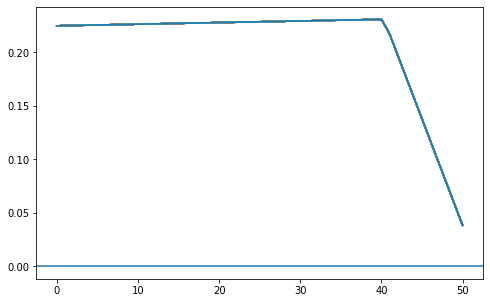

In [27]:
plt.plot(B1[:, -1, :])
plt.axhline(0)
plt.show()

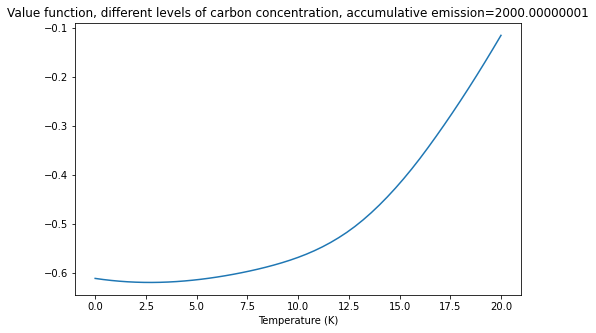

In [28]:
ii = -1
plt.plot(T_grid, v0[:, -1, ii])
plt.xlabel("Temperature (K)")
plt.title("Value function, different levels of carbon concentration, accumulative emission={}".format(F_grid[ii]))
plt.show()

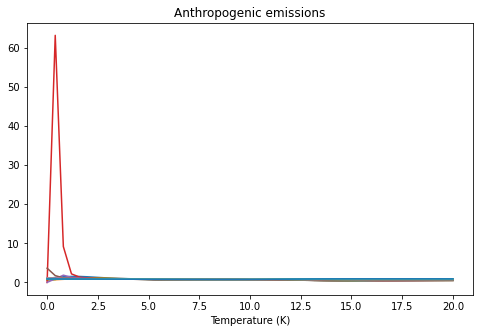

In [29]:
plt.plot(T_grid, Ca[:, :, 6])
plt.xlabel("Temperature (K)")
plt.title("Anthropogenic emissions")
plt.show()

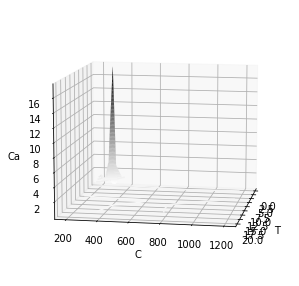

In [30]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(T_mat[:, :, 10], C_mat[:, :, 10], Ca[:, :, ii], 90, cmap='binary')
ax.set_xlabel('T')
ax.set_ylabel('C')
ax.set_zlabel('Ca')
ax.view_init(10, 10)

In [2]:
(870 - 580) / 2.13

136.15023474178403

In [31]:
t_max = 600.
dt = 1/12
dt = 1  # , Gigaton per year
gridpoints = (T_grid, C_grid, F_grid)   
Ca_func = RegularGridInterpolator(gridpoints, Ca)

T_0 = To + min(T_grid)
C_0 = 275.5
F_0 = min(F_grid) #(870 - 580) / 2.13 # total cumulated, as of now, preindustrial with Fo

T_0 = To + 1.1
C_0 = 417
F_0 = (870 - 580) / 2.13

def get_e(x):
    return Ca_func([x[0] - To, x[1], x[2]])

# Ocean albedo
def alphaocean_1d(T):
    if T < Talphaocean_low:
        return alphaocean_max
    elif T < Talphaocean_high:
        return alphaocean_max + (alphaocean_min - alphaocean_max) / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return alphaocean_min

# Vegetation growth function
def veggrowth_1d(T):
    if T < Tlow:
        return 0
    if (T >= Tlow) and (T < Topt1):
        return acc / (Topt1 - Tlow) * (T - Tlow)
    if (T >= Topt1) and (T <= Topt2):
        return acc
    if (T > Topt2) and (T < Thigh):
        #return acc
        return acc / (Topt2 - Thigh) * (T - Thigh)
    if T > Thigh:
        #return acc
        return 0

def oceanatmphysflux_1d(T):
    return 1 / tauc * (coc0 * (np.exp(-bP * (T - T0))))

def fracseaice_1d(T):
    if T < Talphaocean_low:
        return 1
    elif T < Talphaocean_high:
        return 1 - 1 / (Talphaocean_high - Talphaocean_low) * (T - Talphaocean_low)
    else: # so T is higher
        return 0

def biopump_1d(Cc):
    if Cc < Cbio_low:
        return 1
    elif Cc < Cbio_high:
        return 1 - 1 / (Cbio_high - Cbio_low) * (Cc - Cbio_low)
    else: 
        return 0


def oceanbioflux_1d(T, F, sa):
     return 1/tauc * (coc0 * (np.exp(bB * biopump_1d(F) * (T - T0))))

def oceanatmcorrflux_1d(C):
    return 1 / tauc * (- cod * C)


def mu_T(x):
    Ri_t = 1 / cearth * (Q0 * (1 - p * alphaland - (1 - p) * alphaocean(x[0])))
    Ro_t = 1 / cearth * (kappa * (x[0] - Tkappa) -  B * np.log(x[1] / C0))
    return Ri_t - Ro_t

def mu_C(x):
    Ca_t = Ca_func([x[0] - To, x[1], x[2]])
    dC = Volcan
    dC += Ca_t * sa
    dC -= wa * x[1] * vegcover * veggrowth_1d(x[0])
    dC += oceanatmphysflux_1d(x[0]) * (1 - fracseaice_1d(x[0]))
    dC += oceanbioflux_1d(x[0], x[2], sa) * (1 - fracseaice_1d(x[0]))
    dC += oceanatmcorrflux_1d(x[1]) * (1 - fracseaice_1d(x[0]))
    return dC

def mu_Sa(x):
    return Ca_func([x[0] - To, x[1], x[2]])

years  = np.arange(0, t_max + dt, dt)
pers   = len(years)

hist      = np.zeros([pers, 3])
e_hist    = np.zeros([pers])


for tm in range(pers):
    if tm == 0:
        # initial points
        hist[0,:] = [T_0, C_0, F_0] # logL
        e_hist[0] = get_e(hist[0, :])

    else:
        # other periods
        e_hist[tm] = get_e(hist[tm-1,:])

        hist[tm,0] = max(hist[tm-1,0] + mu_T(hist[tm-1,:]) * dt, To + min(T_grid))
        hist[tm,1] = hist[tm-1,1] + mu_C(hist[tm-1,:]) * dt
        hist[tm,2] = hist[tm-1,2] + mu_Sa(hist[tm-1,:]) * dt


In [32]:
min(T_grid), hist

(1e-08,
 array([[283.97      , 417.        , 136.15023474],
        [284.03361896, 415.98802531, 137.0585891 ],
        [284.09689046, 414.91776171, 137.96497819],
        ...,
        [282.87000001, 241.78999755, 513.87359552],
        [282.87000001, 241.9813725 , 514.49104234],
        [282.87000001, 242.17230949, 515.10847123]]))

Text(0.5, 1.0, '$S_a$')

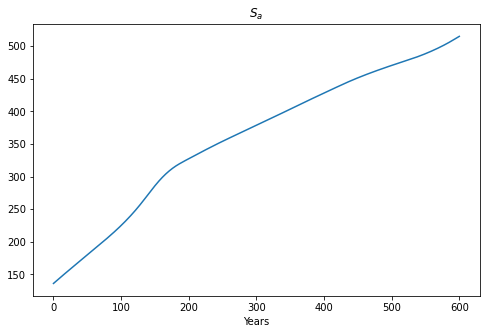

In [33]:
plt.plot(years[:], hist[:, 2])
plt.xlabel("Years")
plt.title("$S_a$")

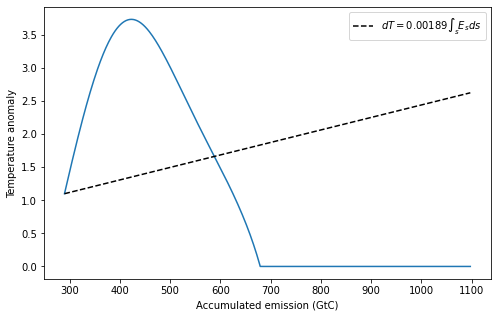

In [34]:
plt.plot(hist[:, 2] * 2.13, hist[:, 0] - To)
plt.plot(hist[:, 2] * 2.13, 1.1 +  (hist[:, 2] - hist[0, 2]) * 2.13 * 0.00189, 
         linestyle="dashed", color="black", label="$dT = 0.00189 \int_s E_s ds$")
plt.xlabel("Accumulated emission (GtC)")
plt.ylabel("Temperature anomaly")
plt.legend()
# plt.savefig("T_F_35.pdf")

In [35]:
e_hist

array([0.90835436, 0.90835436, 0.9063891 , 0.90450251, 0.90272339,
       0.90094833, 0.89917659, 0.89740745, 0.89564027, 0.89387448,
       0.89229091, 0.89072181, 0.8891609 , 0.8876081 , 0.88608654,
       0.88463859, 0.88320844, 0.88192822, 0.88065754, 0.87939647,
       0.87814508, 0.87690352, 0.87567195, 0.87445058, 0.87333332,
       0.87233656, 0.87141923, 0.87051508, 0.86962445, 0.8687481 ,
       0.86788574, 0.8670377 , 0.86622614, 0.86547264, 0.86479524,
       0.86427459, 0.86376939, 0.86327999, 0.86280677, 0.86235014,
       0.86191053, 0.86148838, 0.8610821 , 0.86084919, 0.86072734,
       0.86061922, 0.86052556, 0.8604471 , 0.86038461, 0.86033888,
       0.86031072, 0.86034021, 0.86066746, 0.8609978 , 0.86133321,
       0.86167568, 0.86202722, 0.86238984, 0.8627562 , 0.86314235,
       0.86370687, 0.86448712, 0.86528087, 0.86609082, 0.86691962,
       0.86776988, 0.8686442 , 0.86954511, 0.87047511, 0.87168079,
       0.87365051, 0.87564216, 0.87766034, 0.87970951, 0.88179

(-0.1, 2.981972221371938)

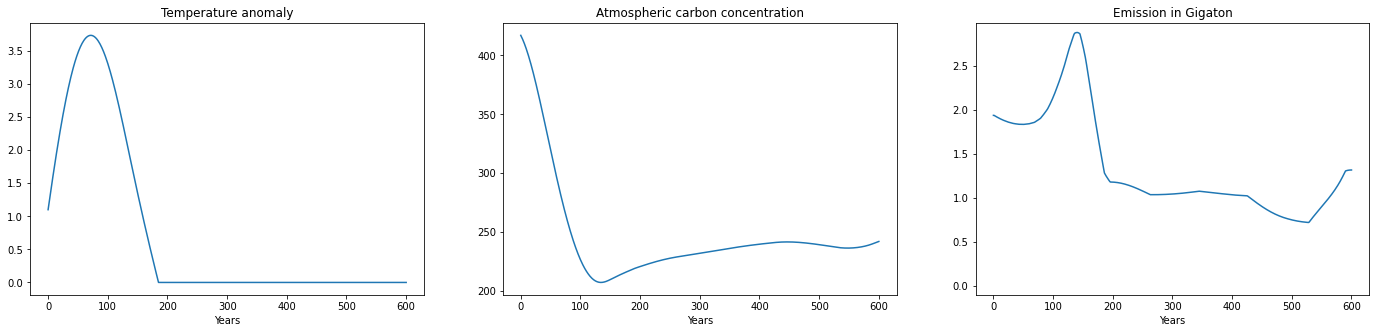

In [36]:
plt.subplots(1,3, figsize=(24,5))
plt.subplot(131)
plt.plot(years, hist[:, 0] - To)
plt.xlabel("Years")
plt.title("Temperature anomaly")
plt.subplot(132)
plt.plot(years, hist[:, 1])
plt.xlabel("Years")
plt.title("Atmospheric carbon concentration")
plt.subplot(133)
plt.plot(years, e_hist * 2.13)
plt.xlabel("Years")
plt.title("Emission in Gigaton")
plt.ylim(-0.1)
# plt.savefig(f"T_C_E_{cearth}_{tauc}.pdf")

In [96]:
res = {
    "v0": v0,
    "T": T_grid,
    "C": C_grid,
    "F": F_grid,
    "Ca": Ca,
}

pickle.dump(res, open(f"./data_{cearth}_{tauc}", "wb"))

In [409]:
Et = e_hist * 2.13

Text(0.5, 1.0, 'Emission in GtC')

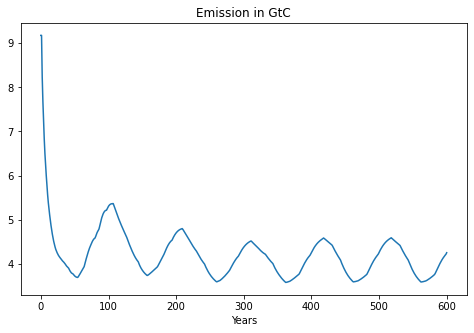

In [410]:
plt.plot(years, Et)
plt.xlabel("Years")
plt.title("Emission in GtC")

In [35]:
# df = pd.DataFrame({
#     'Years': years,
#     'Et(Gigaton)': Et,
#                   })

# df.to_csv("Et.csv", index=False)